Recommendation system

A recommender system is an information filtering system that seeks to predicts the rating given by a user to an item. This predicted rating then used to recommend items to the user. The item for which the predicted rating is high will be recommended to the user. This recommender system is utilized in recommendation of a broad range of items. For instance, it can be used to recommend movies, products, videos, music, books, news, Facebook friends, clothes, Twitter pages, Android/ios apps, hotels, restaurants, routes etc. It is used by almost all of the major companies to enhance their business and to enrich user experience like YouTube for recommending videos, Amazon & Ebay for recommending products, Netflix for recommending Movies, Airbnb for recommending rooms and hotels, Facebook for recommending friends etc.

Types of recommendations
There are mainly 6 types of the recommendations systems :-

Popularity based systems :- It works by recommeding items viewed and purchased by most people and are rated high.It is not a personalized recommendation.

Classification model based:- It works by understanding the features of the user and applying the classification algorithm to decide whether the user is interested or not in the prodcut.

Content based recommedations:- It is based on the information on the contents of the item rather than on the user opinions.The main idea is if the user likes an item then he or she will like the "other" similar item.

Collaberative Filtering:- It is based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste. it is mainly of two types: a) User-User b) Item -Item

Hybrid Approaches:- This system approach is to combine collaborative filtering, content-based filtering, and other approaches .

Association rule mining :- Association rules capture the relationships between items based on their patterns of co-occurrence across transactions.

Data Description

Amazon Reviews data. The repository has several datasets. For this case study, we are using the Electronics dataset.

Context:

Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

Problem Statement:

To build a recommendation system to recommend products to customers based on their previous ratings of other products

Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline



C:\Users\Work\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Loading the dataset and addiding Headers

In [2]:
my_file_location = "ratings_Electronics.xlsx"
e_data = pd.read_excel(my_file_location, sheet_name='ratings_Electronics',names=['userId', 'productId','Rating','timestamp'])


Attribute Information:

● userId : Every user identified with a unique id

● productId : Every product identified with a unique id

● Rating : Rating of the corresponding product by the corresponding user

● timestamp : Time of the rating

In [3]:
e_data.head()


,userId,productId,Rating,timestamp
0,A2CX7LUOHB2NDG,321732944,5,1341100800
1,A2NWSAGRHCP8N5,439886341,1,1367193600
2,A2WNBOD3WNDNKT,439886341,3,1374451200
3,A1GI0U4ZRJA8WN,439886341,1,1334707200
4,A1QGNMC6O1VW39,511189877,5,1397433600


In [4]:
e_data.shape

(1048575, 4)

given dataset has 1048575 records and 4 attributes

In [5]:
e_data.dtypes



userId       object
productId    object
Rating        int64
timestamp     int64
dtype: object

In [6]:
#converting the ratings to float , because some ratings can be like 3.5, 2.5
e_data['Rating'] = e_data['Rating'].astype('float')


In [7]:
e_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
userId       1048575 non-null object
productId    1048575 non-null object
Rating       1048575 non-null float64
timestamp    1048575 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [8]:
e_data.describe()['Rating'].T

count    1.048575e+06
mean     3.973379e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [9]:
#minimum rating is 1 rating
#mean rating is 3.9 whereas median (50%) is at 5.0 data may be skewed to the right, 
#maximum rating is 5


In [10]:
#Check for missing values
print('Number of missing values across columns: \n',e_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


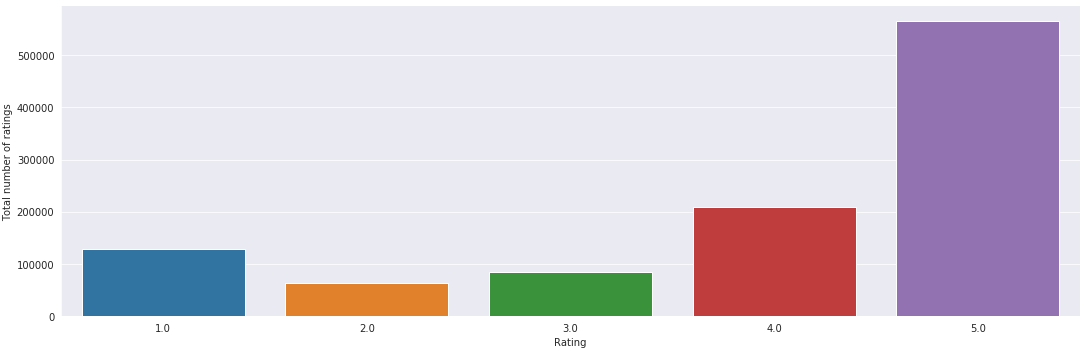

In [11]:
# Check the distribution of the rating
with sns.axes_style('darkgrid'):
    g = sns.factorplot("Rating", data=e_data, aspect=3.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [12]:
#majority of ratings are 5 
# next highest ratings are 4
# 2.0 ratings are less in frequency than the other ratings

In [13]:
#Dropping the Timestamp column as it is not required for recommendations

e_data.drop(['timestamp'], axis=1,inplace=True)

In [14]:

# Number of unique user id  in the data
print('Number of unique users in Raw data = ', e_data['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', e_data['productId'].nunique())

Number of unique users in Raw data =  786329
Number of unique product in Raw data =  61893


### Taking the subset of data to make it less sparser

In [15]:
#Check the top 10 users based on ratings
most_rated=e_data.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
AKT8TGIT6VVZ5     122
A11D1KHM7DVOQK    112
A2B7BUH8834Y6M    103
A3OXHLG6DIBRW8     95
A203OCQQ12MAVT     90
dtype: int64


In [16]:
counts=e_data.userId.value_counts()
e_data_final=e_data[e_data.userId.isin(counts[counts>=50].index)]
print('Number of users who have rated 50 or more items =', len(e_data))
print('Number of unique users in the final data = ', e_data_final['userId'].nunique())
print('Number of unique products in the final data = ', e_data_final['userId'].nunique())

Number of users who have rated 50 or more items = 1048575
Number of unique users in the final data =  38
Number of unique products in the final data =  38


e_data_final has the users who have rated 50 or more items

In [17]:
e_data_final.head()

,userId,productId,Rating
2161,A5JLAU2ARJ0BO,1400532655,1.0
3049,ALUNVOQRXOZIA,1400599997,1.0
4613,A1VQHH85U7PX0,9043413585,3.0
6071,A250AXLRBVYKB4,998376234X,1.0
7380,A2AEZQ3DGBBLPR,B000000O48,5.0



#### Ratings analysis in final dataset

In [18]:
#constructing the pivot table
final_ratings_matrix = e_data_final.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
final_ratings_matrix.head()

productId,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1435P5AMCPB3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A15QYHQH80W30L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It shows that it is a sparse matrix. So, many cells are filled with 0 values.

In [19]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (38, 2943)


In [20]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  3456
possible_num_of_ratings =  111834
density: 3.09%


### Splitting the data into train and test

In [21]:
#Splitting the dataset
trainset, testset = train_test_split(e_data_final, test_size=0.3,random_state=10)

In [22]:
trainset.head()

,userId,productId,Rating
499469,A680RUE1FDO8B,B0002OKCX4,3.0
31740,A203OCQQ12MAVT,B00002NAXD,5.0
1048157,A2XRMQA6PJ5ZJ8,B000IF4788,4.0
823981,AKT8TGIT6VVZ5,B000DZFWL4,5.0
37575,A7Y6AVS576M03,B00004RG85,5.0


In [24]:
print('Shape of training data: ',trainset.shape)
print('Shape of testing data: ',testset.shape)

Shape of training data:  (2419, 3)
Shape of testing data:  (1037, 3)


### Building a Popularity Based Model

Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.

In [27]:
#Count of user_id for each unique product as recommendation score 
trainset_grouped = trainset.groupby('productId').agg({'userId': 'count'}).reset_index()
trainset_grouped.rename(columns = {'userId': 'score'},inplace=True)
trainset_grouped.head(10)

,productId,score
0,1400532655,1
1,9043413585,1
2,998376234X,1
3,B000000O48,1
4,B000001OL6,1
5,B000001OMI,1
6,B000001OMN,1
7,B00000J05A,1
8,B00000J061,2
9,B00000J0A2,1


In [28]:
#Sort the products on recommendation score 
trainset_sort = trainset_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
trainset_sort['rank'] = trainset_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = trainset_sort.head(5) 
popularity_recommendations

,productId,score,rank
103,B00004SB92,6,1.0
346,B00005LEN4,4,2.0
767,B00007KDVI,4,3.0
859,B00008OE46,4,4.0
860,B00008OE5G,4,5.0


In [29]:

# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [33]:
find_recommendation = [20,40,100,200]   # This list is user choice.
for i in find_recommendation:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")


The list of recommendations for the userId: 20

     userId   productId  score  rank
103      20  B00004SB92      6   1.0
346      20  B00005LEN4      4   2.0
767      20  B00007KDVI      4   3.0
859      20  B00008OE46      4   4.0
860      20  B00008OE5G      4   5.0


The list of recommendations for the userId: 40

     userId   productId  score  rank
103      40  B00004SB92      6   1.0
346      40  B00005LEN4      4   2.0
767      40  B00007KDVI      4   3.0
859      40  B00008OE46      4   4.0
860      40  B00008OE5G      4   5.0


The list of recommendations for the userId: 100

     userId   productId  score  rank
103     100  B00004SB92      6   1.0
346     100  B00005LEN4      4   2.0
767     100  B00007KDVI      4   3.0
859     100  B00008OE46      4   4.0
860     100  B00008OE5G      4   5.0


The list of recommendations for the userId: 200

     userId   productId  score  rank
103     200  B00004SB92      6   1.0
346     200  B00005LEN4      4   2.0
767     200  B00007KDVI

Since, it is a Popularity recommender model, so, all the 4 users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

Let us visualise the popular products based on the number of ratings given

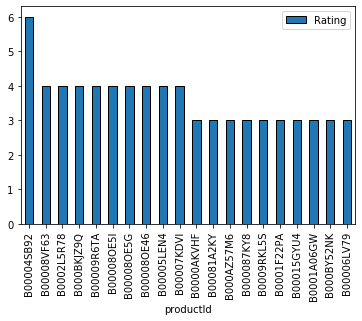

In [36]:
popular_products = pd.DataFrame(trainset.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(20).plot(kind = "bar")

In [47]:
#We can observe that Product with ID B0004SB92 has recieved more than 8000 ratings

### Collaborative filtering

In [38]:
e_df_CF = pd.concat([trainset, testset]).reset_index()
e_df_CF.head()

,index,userId,productId,Rating
0,499469,A680RUE1FDO8B,B0002OKCX4,3.0
1,31740,A203OCQQ12MAVT,B00002NAXD,5.0
2,1048157,A2XRMQA6PJ5ZJ8,B000IF4788,4.0
3,823981,AKT8TGIT6VVZ5,B000DZFWL4,5.0
4,37575,A7Y6AVS576M03,B00004RG85,5.0


In [39]:

# Matrix with row per 'user' and column per 'item' 
pivot_df = e_df_CF.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
pivot_df.head()

productId,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1435P5AMCPB3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A15QYHQH80W30L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:

print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (38, 2943)


In [41]:

#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1435P5AMCPB3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A15QYHQH80W30L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [42]:

pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As this is a sparse matrix we will use SVD.

### Singular Value Decomposition

In [43]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)

In [44]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-6.64161696e-02  4.31528153e-04  3.37786414e-03  4.12558392e-02
  -2.89722101e-02  1.79284225e-02  3.02342026e-03 -3.52112579e-04
   2.45397452e-03  1.04887971e-02]
 [-1.80197050e-02  7.68657333e-04  7.20544067e-03  2.62748695e-02
  -1.97320291e-02  1.92531155e-02  1.69864914e-03  5.95174021e-03
  -1.93268622e-02  2.72017747e-02]
 [-6.86727933e-02 -1.49434527e-02  8.11418685e-02  1.90458879e-02
  -8.60896456e-03  2.13284435e-03  3.43354825e-04 -2.10703364e-04
   3.18370938e-03  1.15138368e-02]
 [ 1.53478750e-02  4.83314743e-03 -1.30024203e-02  3.99558068e-02
  -3.46573069e-03  3.87274114e-02  1.88223811e-03 -4.41856025e-07
  -1.09124307e-02  6.90452643e-03]
 [-7.19210074e-03  1.99921755e-03  3.61877490e-02  1.28627831e-02
  -7.04467382e-03 -1.12413800e-03  5.42691695e-02 -1.27481833e-03
   3.13621954e-03  1.13870943e-02]
 [-2.96100557e-02 -7.69782564e-02  4.25563509e-02  2.03047194e-02
  -7.02441403e-02  4.29041203e-02  3.21266108e-02 -3.38399429e-03
  -2.2940

In [45]:
print('Sigma: \n',sigma)

Sigma: 
 [41.89390301 42.28479703 43.75491809 44.00142731 45.99811068 51.84242495
 53.59174684 63.49228847 69.36014162 84.88630491]


As sigma is not a diagonal matrix we have to convert it into diagonal matrix.

In [46]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[41.89390301  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         42.28479703  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         43.75491809  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         44.00142731  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         45.99811068  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         51.84242495
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  53.59174684  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         63.49228847  0.          0.        ]
 [ 0.          0.          0.        

In [47]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 3.00429861e-04 -2.16836488e-04 -1.06233760e-03 ... -4.89206972e-03
  -9.75210221e-03 -3.04423019e-03]
 [ 5.38321607e-05 -1.70440674e-04  5.66590559e-04 ... -1.62514374e-04
  -7.42849482e-03  1.75242360e-03]
 [-1.74432819e-04  2.35572803e-05  2.30102014e-04 ... -2.53627309e-03
  -1.56138806e-04  1.39847434e-03]
 ...
 [-1.42106588e-04  5.60662786e-05 -3.67721847e-05 ...  8.97313402e-05
  -1.74896872e-05 -1.50392450e-03]
 [ 2.85425835e-03 -2.18521938e-04 -6.66857252e-05 ... -2.98607167e-04
  -6.73184268e-05 -1.06387085e-03]
 [ 1.15174070e-02  3.20653634e-05  1.04420164e-04 ...  5.50434939e-04
   5.04878181e-05  1.45121449e-03]]


In [48]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
0,0.008496,0.000975,0.017130,0.009489,0.002576,0.273672,0.006995,0.014822,-0.001294,0.008682,...,0.007360,0.006995,0.042479,0.025488,-0.001294,0.004197,0.060605,0.047444,0.035227,0.026392
1,0.021403,0.000907,0.011784,0.005400,0.006628,0.098021,0.007664,0.006926,0.001527,0.038343,...,0.048133,0.007664,0.107014,0.064208,0.001527,0.004598,0.024748,0.027002,0.013018,0.019467
2,0.009910,0.000870,0.008238,0.004004,0.001872,0.262368,0.034362,0.012063,-0.000689,-0.031076,...,0.353545,0.034362,0.049551,0.029731,-0.000689,0.020617,0.058273,0.020021,0.035347,0.018342
3,0.003421,0.000552,0.013528,0.006192,0.001947,-0.000054,0.000268,0.002867,0.005244,0.102796,...,-0.010295,0.000268,0.017107,0.010264,0.005244,0.000161,0.004767,0.030960,-0.000254,0.010970
4,0.009934,0.000145,0.005831,0.002463,-0.000078,0.046547,0.016904,0.003214,-0.000880,-0.005246,...,0.188454,0.016904,0.049672,0.029803,-0.000880,0.010142,0.011490,0.012314,0.004482,0.022131


In [49]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [57]:
userID = 11
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)



Below are the recommended items for user(user_id = 11):

                   user_ratings  user_predictions
Recommended Items                                
B00005137P                  0.0          0.251214
B0001U6RNI                  0.0          0.241828
B0007OW51Q                  0.0          0.227598
B000EPHSLK                  0.0          0.219321
B0002ILKMW                  0.0          0.215977


In [54]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B00004ZCJE                  0.0          0.579875
B0000UA3MA                  0.0          0.541374
B000GHDPHC                  0.0          0.541374
B0001U6RNI                  0.0          0.528805
B00008GT9Y                  0.0          0.515756


In [55]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B00022TN9A                  0.0          0.827527
B000E6G9RI                  0.0          0.821428
B00021O4UO                  0.0          0.813451
B0001GAMT2                  0.0          0.813451
B0002ZPJZY                  0.0          0.813451


In [56]:
userID = 10
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 10):

                   user_ratings  user_predictions
Recommended Items                                
B00065DGNC                  0.0          0.893152
B00081A2KY                  0.0          0.859868
B00029U1DK                  0.0          0.838796
B000050AQ7                  0.0          0.811351
B0002Z240M                  0.0          0.800835


Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.

### Evaluation of Collaborative filtering

In [58]:
#Actual ratings given by the users
final_ratings_matrix.head()

productId,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1435P5AMCPB3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A15QYHQH80W30L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# Average actual rating for each item
final_ratings_matrix.mean().head()

productId
1400532655    0.026316
1400599997    0.026316
9043413585    0.078947
998376234X    0.026316
B000000O48    0.131579
dtype: float64

In [60]:
# Predicted ratings 
preds_df.head()



productId,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
0,0.008496,0.000975,0.017130,0.009489,0.002576,0.273672,0.006995,0.014822,-0.001294,0.008682,...,0.007360,0.006995,0.042479,0.025488,-0.001294,0.004197,0.060605,0.047444,0.035227,0.026392
1,0.021403,0.000907,0.011784,0.005400,0.006628,0.098021,0.007664,0.006926,0.001527,0.038343,...,0.048133,0.007664,0.107014,0.064208,0.001527,0.004598,0.024748,0.027002,0.013018,0.019467
2,0.009910,0.000870,0.008238,0.004004,0.001872,0.262368,0.034362,0.012063,-0.000689,-0.031076,...,0.353545,0.034362,0.049551,0.029731,-0.000689,0.020617,0.058273,0.020021,0.035347,0.018342
3,0.003421,0.000552,0.013528,0.006192,0.001947,-0.000054,0.000268,0.002867,0.005244,0.102796,...,-0.010295,0.000268,0.017107,0.010264,0.005244,0.000161,0.004767,0.030960,-0.000254,0.010970
4,0.009934,0.000145,0.005831,0.002463,-0.000078,0.046547,0.016904,0.003214,-0.000880,-0.005246,...,0.188454,0.016904,0.049672,0.029803,-0.000880,0.010142,0.011490,0.012314,0.004482,0.022131


In [61]:
# Average PREDICTED rating for each item
preds_df.mean().head()


productId
1400532655    0.030646
1400599997    0.002071
9043413585    0.025324
998376234X    0.009998
B000000O48    0.008305
dtype: float64

In [62]:

rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(2943, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
1400532655,0.026316,0.030646,0
1400599997,0.026316,0.002071,1
9043413585,0.078947,0.025324,2
998376234X,0.026316,0.009998,3
B000000O48,0.131579,0.008305,4


In [63]:

RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.07375 



### Item-Item based Collaborative filtering

In [71]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [67]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(e_data_final,reader)

In [68]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [72]:

algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [73]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [75]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.1984


1.198350068522711

### Getting top 5 recommendations for user id 

In [64]:

# Enter 'userID' and 'num_recommendations' for the user #
userID = 20
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B000050AQ7                  0.0          0.200175
B00005LB8P                  0.0          0.176587
B0000632FZ                  0.0          0.170667
B00006JI6U                  0.0          0.168738
B0000898TE                  0.0          0.164765


In [65]:

# Enter 'userID' and 'num_recommendations' for the user #
userID = 10
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 10):

                   user_ratings  user_predictions
Recommended Items                                
B00065DGNC                  0.0          0.893152
B00081A2KY                  0.0          0.859868
B00029U1DK                  0.0          0.838796
B000050AQ7                  0.0          0.811351
B0002Z240M                  0.0          0.800835


### Insights

The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 6,8,10 & 11 The Popularity based model has recommended the same set of 5 products to all

but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.